<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-22-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [90]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-3:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-05-20,1542594,87472,21342.0,1402.0
2020-05-21,1567552,88895,24958.0,1423.0
2020-05-22,1591475,90156,23923.0,1261.0


In [167]:
dfCovidtracking[dfCovidtracking.state=='CA'][['positive', 'death', 'positiveIncrease', 'deathIncrease']].head(5)

,positive,death,positiveIncrease,deathIncrease
5,88444,3630,2247.0,88.0
61,86197,3542,2140.0,106.0
117,84057,3436,2262.0,102.0
173,81795,3334,1365.0,32.0
229,80430,3302,1591.0,41.0


In [92]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

Total positive cases = 1591475
Total deaths = 90156


,date,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
state,,,,,,,,,,,,,,,,,,,,,,,,,,
NY,2020-05-22,358154,1242639,0,4844.0,76843.0,1581.0,0.0,1254.0,0.0,63292.0,A,5/22/2020 00:00,7a868b50c6d1915aad6db991e67706058d43cec8,2020-05-22T20:00:00Z,23195,76843.0,1600793,1600793,1600793,36,112.0,235.0,44042.0,1696.0,45738.0
NJ,2020-05-22,152719,402595,0,3049.0,0.0,846.0,0.0,674.0,0.0,24491.0,A+,5/22/2020 13:00,bbd4cb6e09dbbb1bab39a0694510d211894b4f66,2020-05-22T20:00:00Z,10985,0.0,555314,555314,555314,34,142.0,0.0,9793.0,1247.0,11040.0
IL,2020-05-22,105444,591689,0,3928.0,0.0,1060.0,0.0,589.0,0.0,0.0,A,5/22/2020 00:00,798096ecc1907d2bd4de3b45b84a96ca5a50e48b,2020-05-22T20:00:00Z,4715,0.0,697133,697133,697133,17,108.0,0.0,22355.0,2758.0,25113.0
MA,2020-05-22,90889,420755,0,2323.0,9162.0,628.0,0.0,0.0,0.0,0.0,A,5/22/2020 10:00,b9b7162848a82c080d7098c9c00341cdb3cf83f7,2020-05-22T20:00:00Z,6228,9162.0,511644,511644,511644,25,80.0,122.0,9353.0,805.0,10158.0
CA,2020-05-22,88444,1378329,0,4762.0,0.0,1317.0,0.0,0.0,0.0,0.0,B,5/21/2020 00:00,f191cda4632c6bfdfab3cda971a53607f6beaf43,2020-05-22T20:00:00Z,3630,0.0,1466773,1466773,1466773,06,88.0,0.0,43399.0,2247.0,45646.0


In [0]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [94]:
dfUSAPos[-7:]


,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,pos_pct
115,2020-05-16,1459695,11057511,83015,25032.0,1286.0,0.917196
116,2020-05-17,1480473,11460319,83854,20778.0,839.0,0.930252
117,2020-05-18,1500312,11806021,84640,19839.0,786.0,0.942718
118,2020-05-19,1521252,12202812,86070,20940.0,1430.0,0.955876
119,2020-05-20,1542594,12608216,87472,21342.0,1402.0,0.969286
120,2020-05-21,1567552,13024762,88895,24958.0,1423.0,0.984968
121,2020-05-22,1591475,13417877,90156,23923.0,1261.0,1.000000


In [95]:
dfStatePos[-7:]

,date,positive,totalTestResults,death,positiveIncrease,deathIncrease,pos_pct
73,2020-05-16,76793,1179126,3204,1857.0,96.0,0.868267
74,2020-05-17,78839,1235243,3261,2046.0,57.0,0.891400
75,2020-05-18,80430,1292672,3302,1591.0,41.0,0.909389
76,2020-05-19,81795,1339316,3334,1365.0,32.0,0.924822
77,2020-05-20,84057,1380120,3436,2262.0,102.0,0.950398
78,2020-05-21,86197,1421127,3542,2140.0,106.0,0.974594
79,2020-05-22,88444,1466773,3630,2247.0,88.0,1.000000


In [96]:
gbUSA.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-18,1500312,10305709,3596,40933.0,157963.0,10015.0,7064.0,5257.0,602.0,283178.0,84640,157963.0,11809617,11806021,11806021,786.0,1058.0,325863.0,19839.0,345702.0
2020-05-19,1521252,10681560,2944,41174.0,159634.0,9829.0,7217.0,5032.0,606.0,289392.0,86070,159634.0,12205756,12202812,12202812,1430.0,1671.0,375851.0,20940.0,396791.0
2020-05-20,1542594,11065622,2973,40884.0,161616.0,9829.0,7319.0,4911.0,613.0,294312.0,87472,161616.0,12611189,12608216,12608216,1402.0,1982.0,384062.0,21342.0,405404.0
2020-05-21,1567552,11457210,3641,39915.0,166254.0,9090.0,7412.0,4868.0,616.0,298418.0,88895,166254.0,13028403,13024762,13024762,1423.0,4638.0,391588.0,24958.0,416546.0
2020-05-22,1591475,11826402,3709,38802.0,170697.0,9048.0,7689.0,4716.0,633.0,350135.0,90156,170697.0,13421586,13417877,13417877,1261.0,4443.0,369192.0,23923.0,393115.0


In [97]:
gbState.sum()[-5:]

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
date,,,,,,,,,,,,,,,,,,,,
2020-05-18,80430,1212242,0,4391.0,0.0,1325.0,0.0,0.0,0.0,0.0,3302,0.0,1292672,1292672,1292672,41.0,0.0,55838.0,1591.0,57429.0
2020-05-19,81795,1257521,0,4363.0,0.0,1307.0,0.0,0.0,0.0,0.0,3334,0.0,1339316,1339316,1339316,32.0,0.0,45279.0,1365.0,46644.0
2020-05-20,84057,1296063,0,4681.0,0.0,1345.0,0.0,0.0,0.0,0.0,3436,0.0,1380120,1380120,1380120,102.0,0.0,38542.0,2262.0,40804.0
2020-05-21,86197,1334930,0,4735.0,0.0,1310.0,0.0,0.0,0.0,0.0,3542,0.0,1421127,1421127,1421127,106.0,0.0,38867.0,2140.0,41007.0
2020-05-22,88444,1378329,0,4762.0,0.0,1317.0,0.0,0.0,0.0,0.0,3630,0.0,1466773,1466773,1466773,88.0,0.0,43399.0,2247.0,45646.0


In [98]:
rn = gbState.sum().loc['2020-05-02']
rn.positive/rn.totalTestResults*100

7.599995923139533

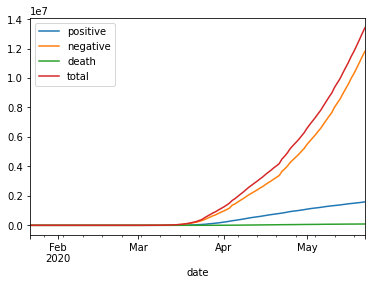

In [99]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

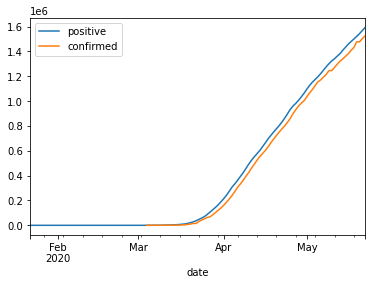

In [100]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [101]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

confirmed    1600937
dead           95979
dtype: int64

In [102]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

confirmed    90252
dead          3666
dtype: int64

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [104]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

country
US                1600937
Brazil             330890
Russia             326448
United Kingdom     255544
Spain              234824
Italy              228658
France             182015
Germany            179710
Turkey             154500
Iran               131652
Name: confirmed, dtype: int64

In [105]:
dfctd_state_curr.head()

,date,total_positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
state,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,2020-05-22,404,41042,0,15.0,0.0,0.0,0.0,0.0,0.0,356.0,C,5/22/2020 00:00,d0241cc63b3eb3c281a53407602d52fb27cdaa8d,2020-05-22T20:00:00Z,10,0.0,41446,41446,41446,02,0.0,0.0,1899.0,2.0,1901.0
AL,2020-05-22,13563,164205,0,0.0,1561.0,0.0,531.0,0.0,315.0,7951.0,B,5/22/2020 00:00,7eda0dcc4aba996231685a7a080b53f03cf69bc4,2020-05-22T20:00:00Z,537,1561.0,177768,177768,177768,01,8.0,33.0,6585.0,444.0,7029.0
AR,2020-05-22,5612,97435,0,86.0,584.0,0.0,0.0,14.0,110.0,4029.0,A,5/22/2020 00:00,35e60394d2d416b144d5be68a958715520a80245,2020-05-22T20:00:00Z,113,584.0,103047,103047,103047,05,3.0,49.0,3617.0,154.0,3771.0
AS,2020-05-22,0,124,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C,5/19/2020 00:00,5e2cdb42c23fc0ec6df07e1ceaa71cce399fe6ab,2020-05-22T20:00:00Z,0,0.0,124,124,124,60,0.0,0.0,0.0,0.0,0.0
AZ,2020-05-22,15608,160395,0,796.0,1879.0,311.0,0.0,203.0,0.0,3949.0,A+,5/22/2020 00:00,41983f9684279d8ba339a586feafdacc56d1f04b,2020-05-22T20:00:00Z,775,1879.0,176003,176003,176003,04,12.0,49.0,4083.0,293.0,4376.0


In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [0]:
dfState['pct']=dfState.positive/dfState.total_positive

In [108]:
dfState.loc['FL'].head(7)

,date,positive,death,total_positive,pct
state,,,,,
FL,2020-05-22,49451,2268,49451,1.000000
FL,2020-05-21,48675,2222,49451,0.984308
FL,2020-05-20,47471,2173,49451,0.959960
FL,2020-05-19,46944,2129,49451,0.949303
FL,2020-05-18,46442,2073,49451,0.939152
FL,2020-05-17,45588,2049,49451,0.921882
FL,2020-05-16,44811,2040,49451,0.906170


In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

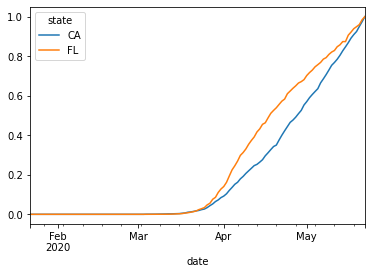

In [110]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

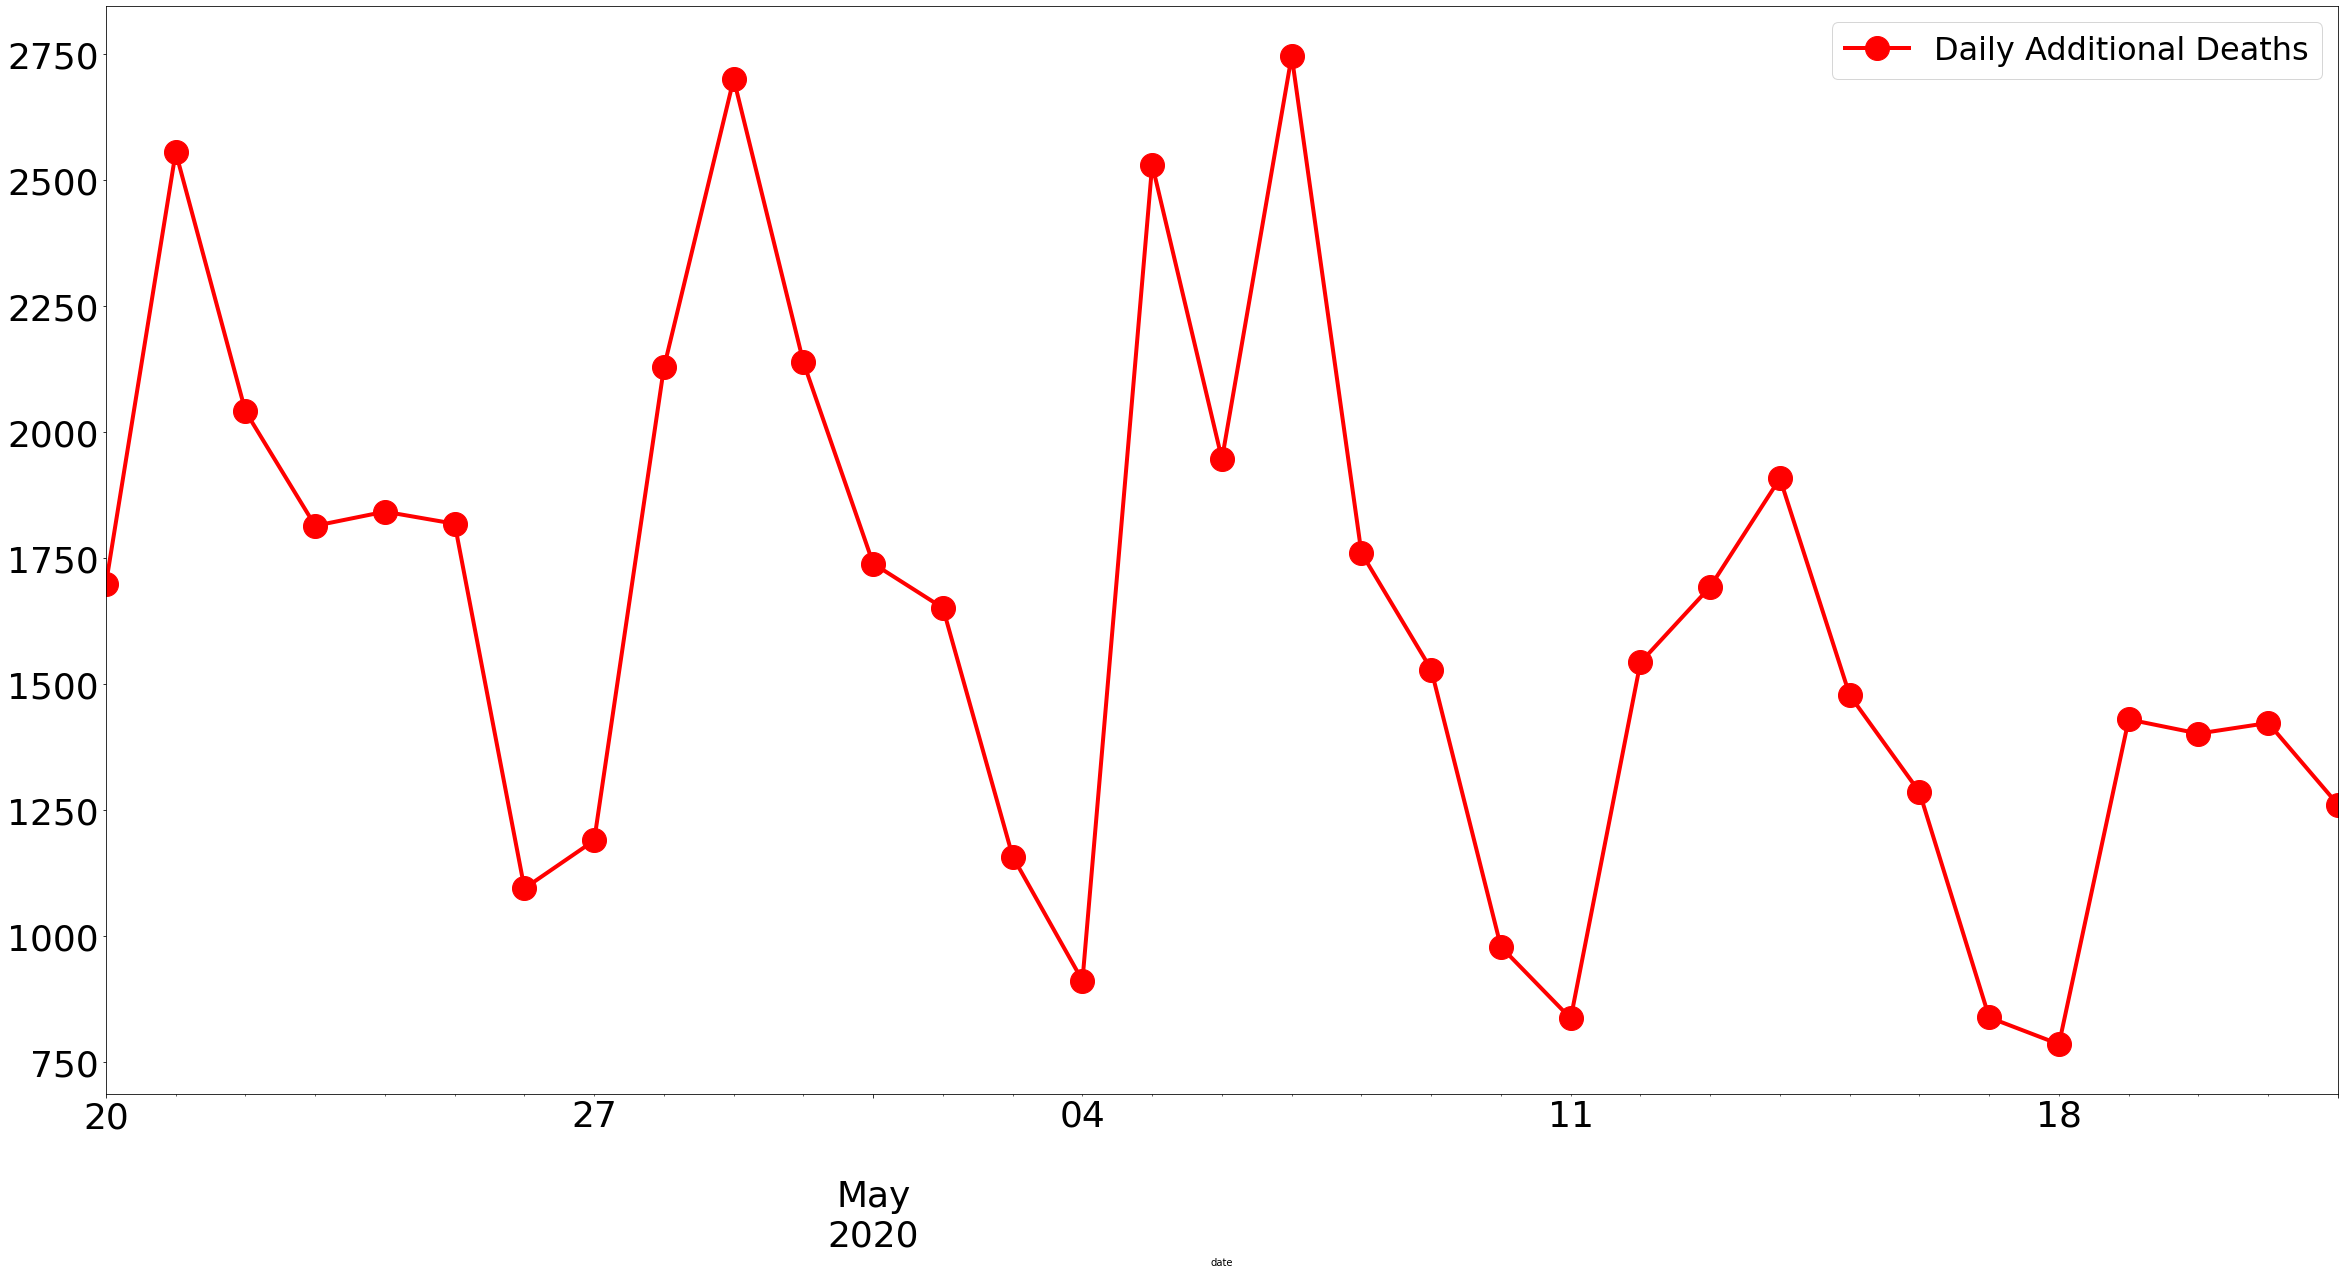

In [112]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


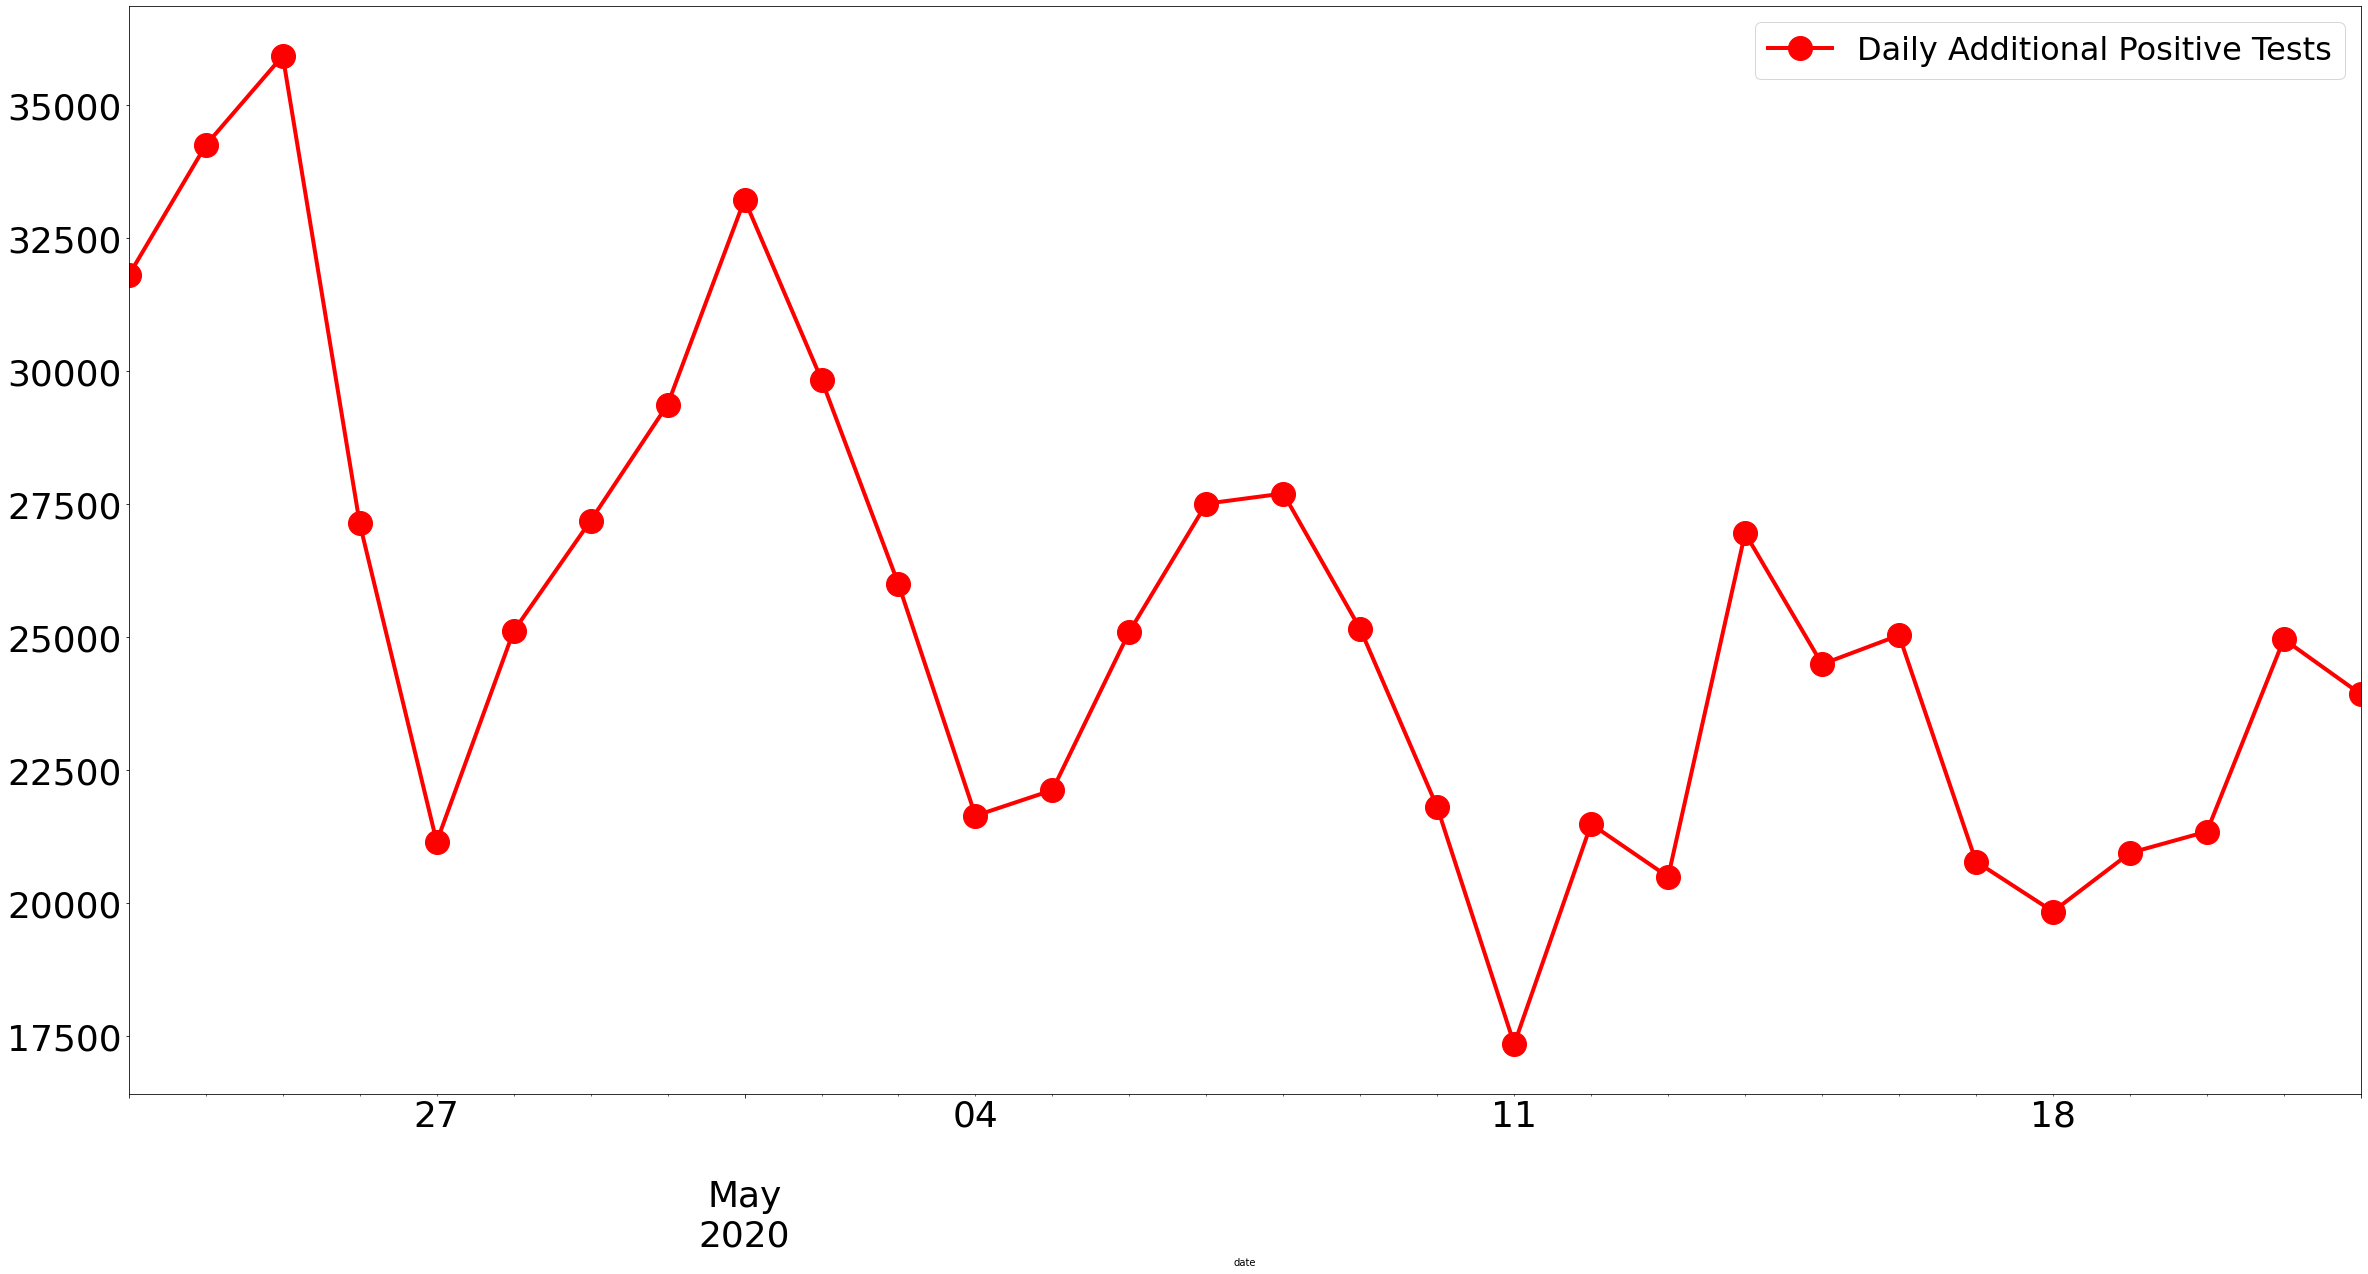

In [113]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()

chart = y1[-30:].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


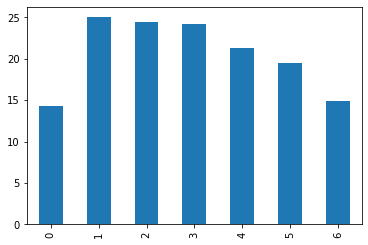

In [116]:
dfDoW.mean().deathIncrease.plot.bar()



In [117]:
dfByWeekYear.sum()[-7:]

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
202015,12523.0,22930.0,834999.0,217011.0,1052010.0
202016,14063.0,21844.0,844332.0,199843.0,1044175.0
202017,12864.0,18239.0,1319356.0,209064.0,1528420.0
202018,12704.0,24854.0,1462961.0,191865.0,1654826.0
202019,12402.0,18984.0,1747407.0,171010.0,1909104.0
202020,9584.0,12125.0,2324282.0,156568.0,2480850.0
202021,6302.0,13792.0,1846556.0,111002.0,1957558.0


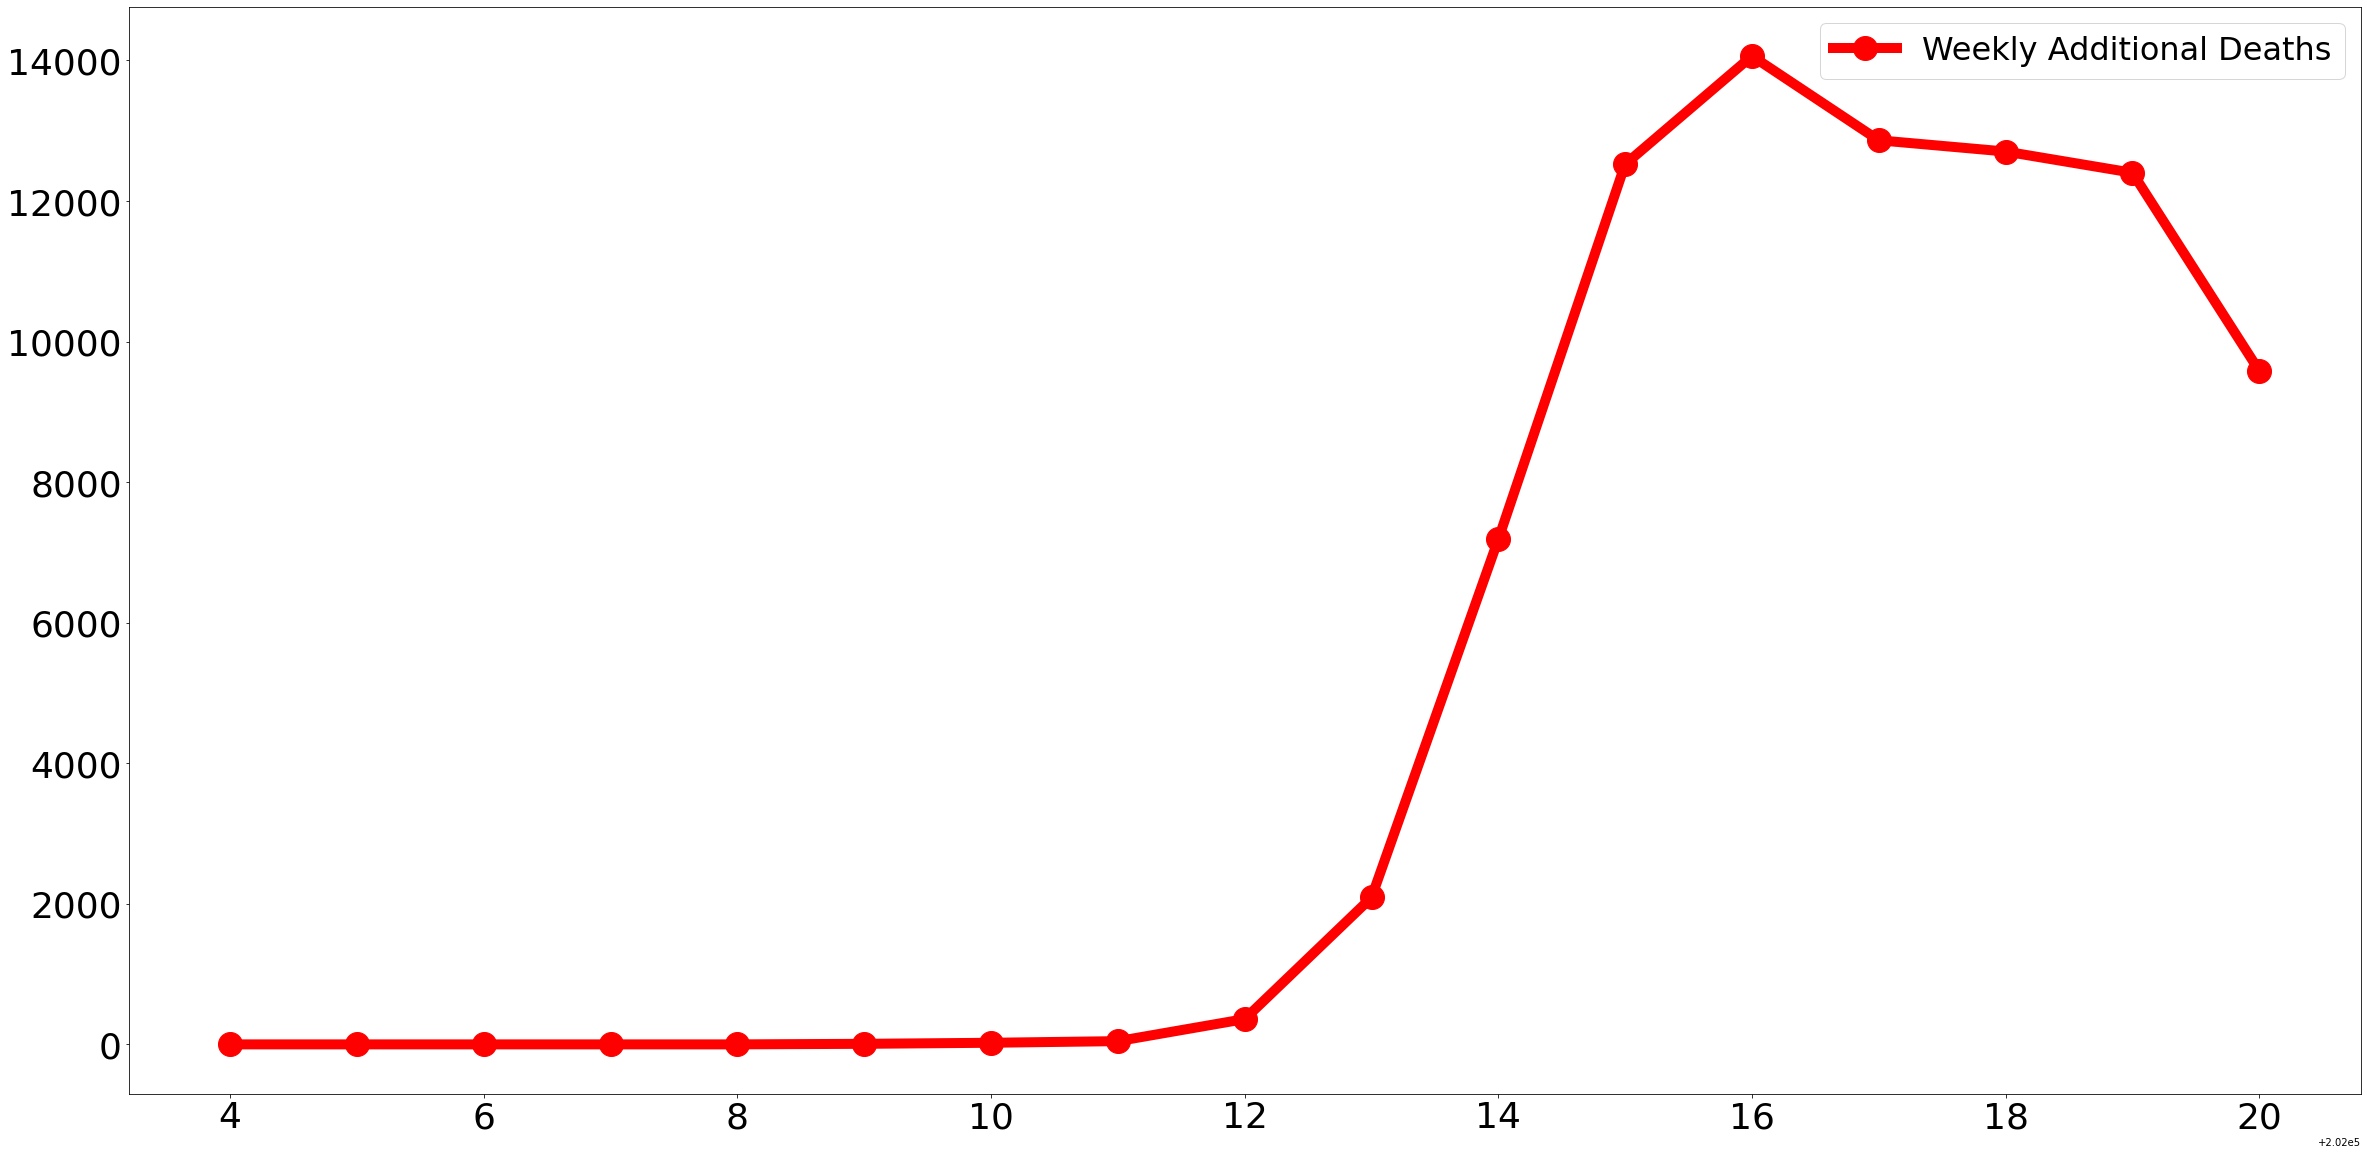

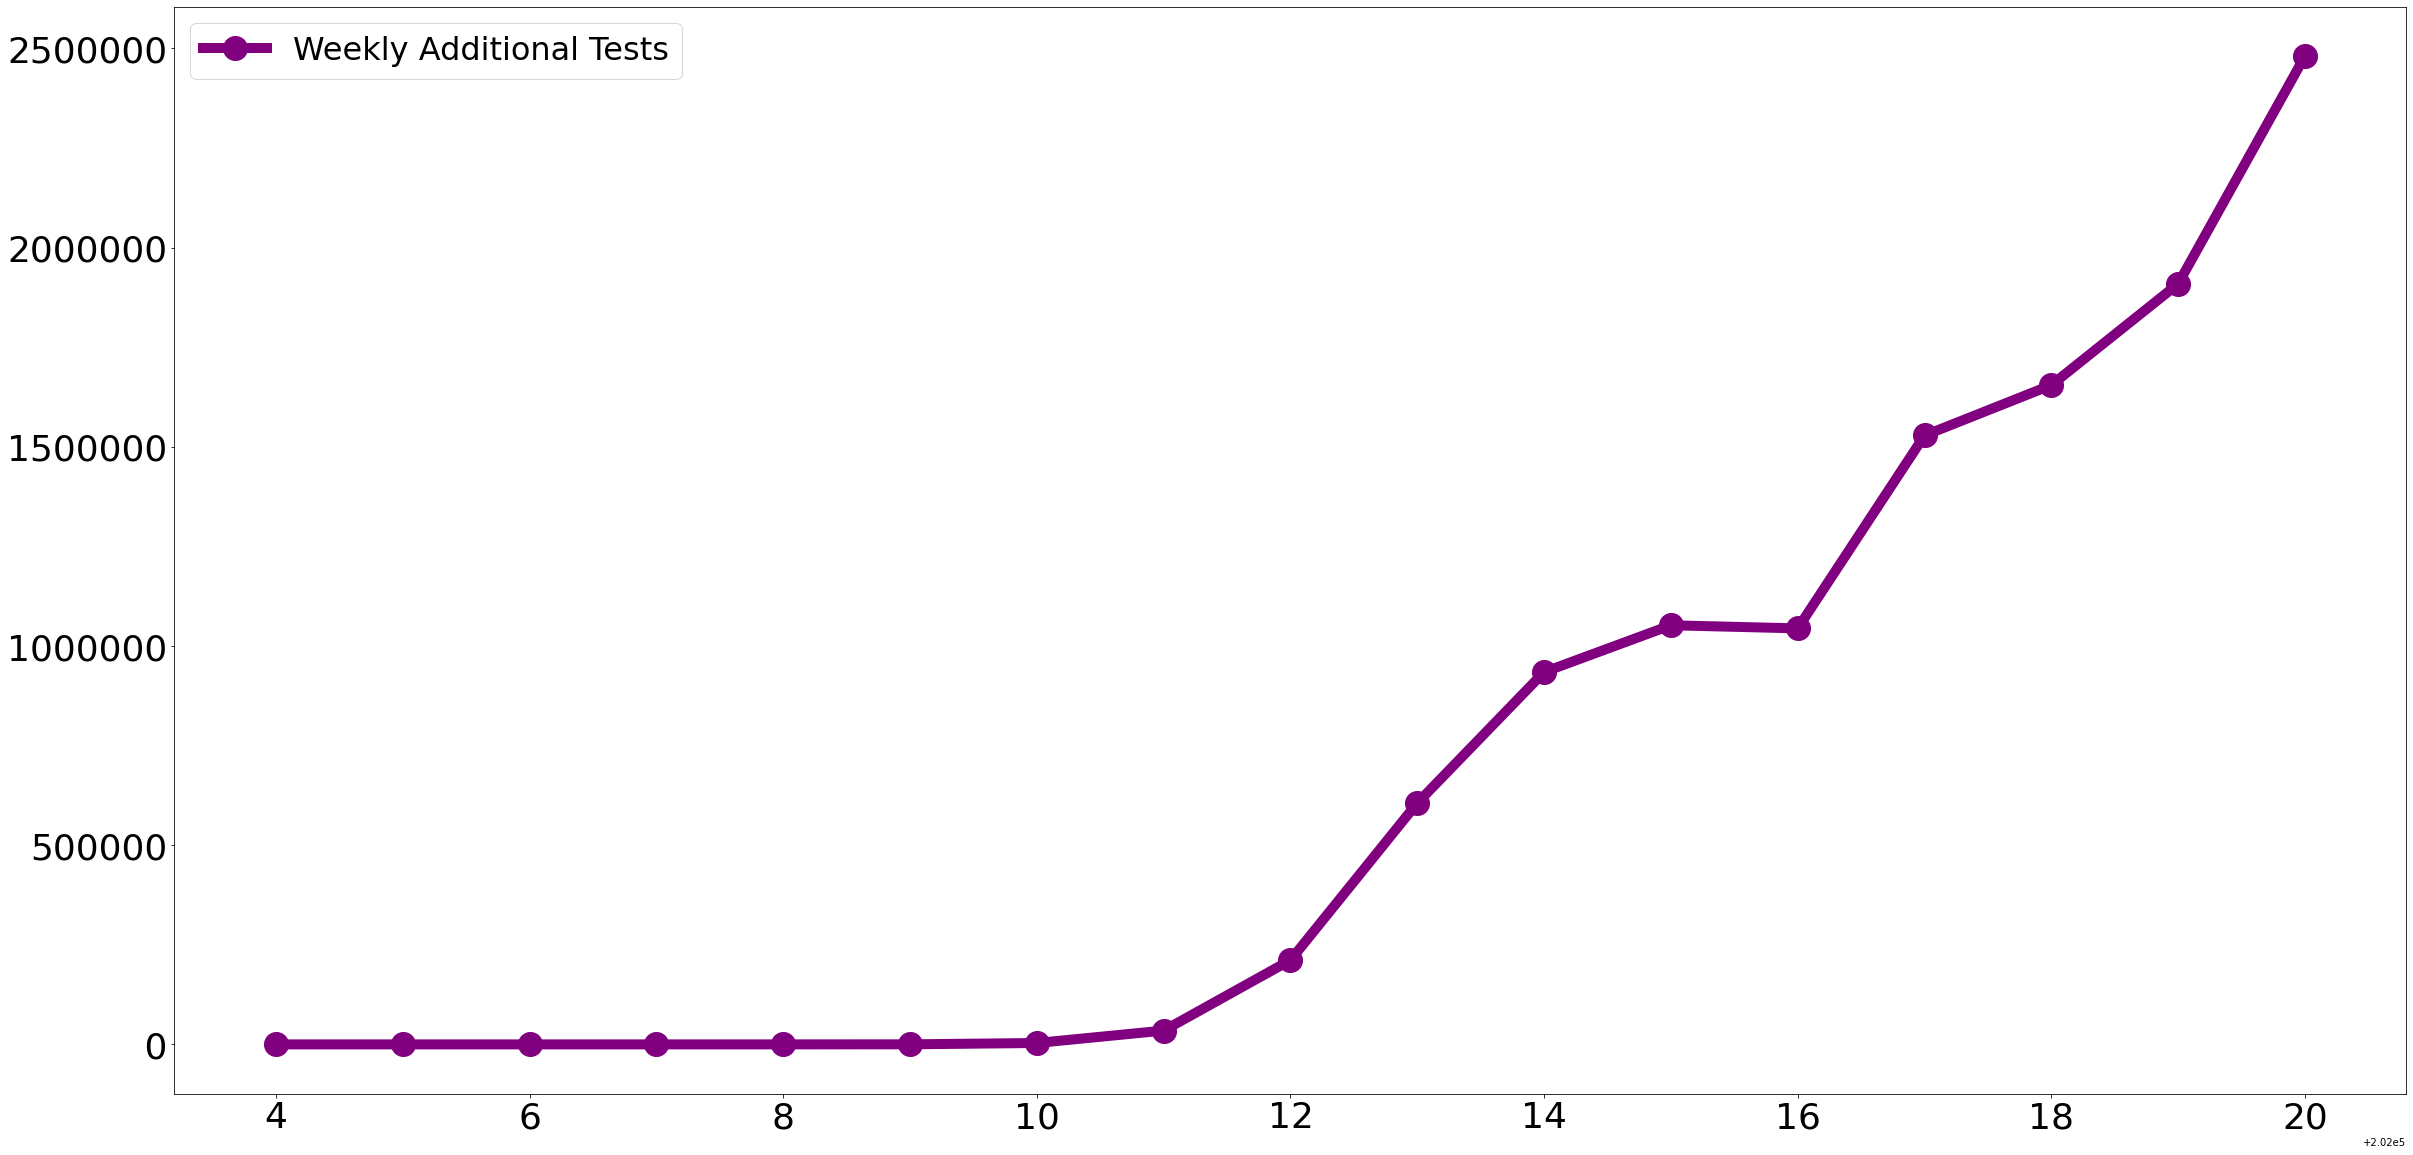

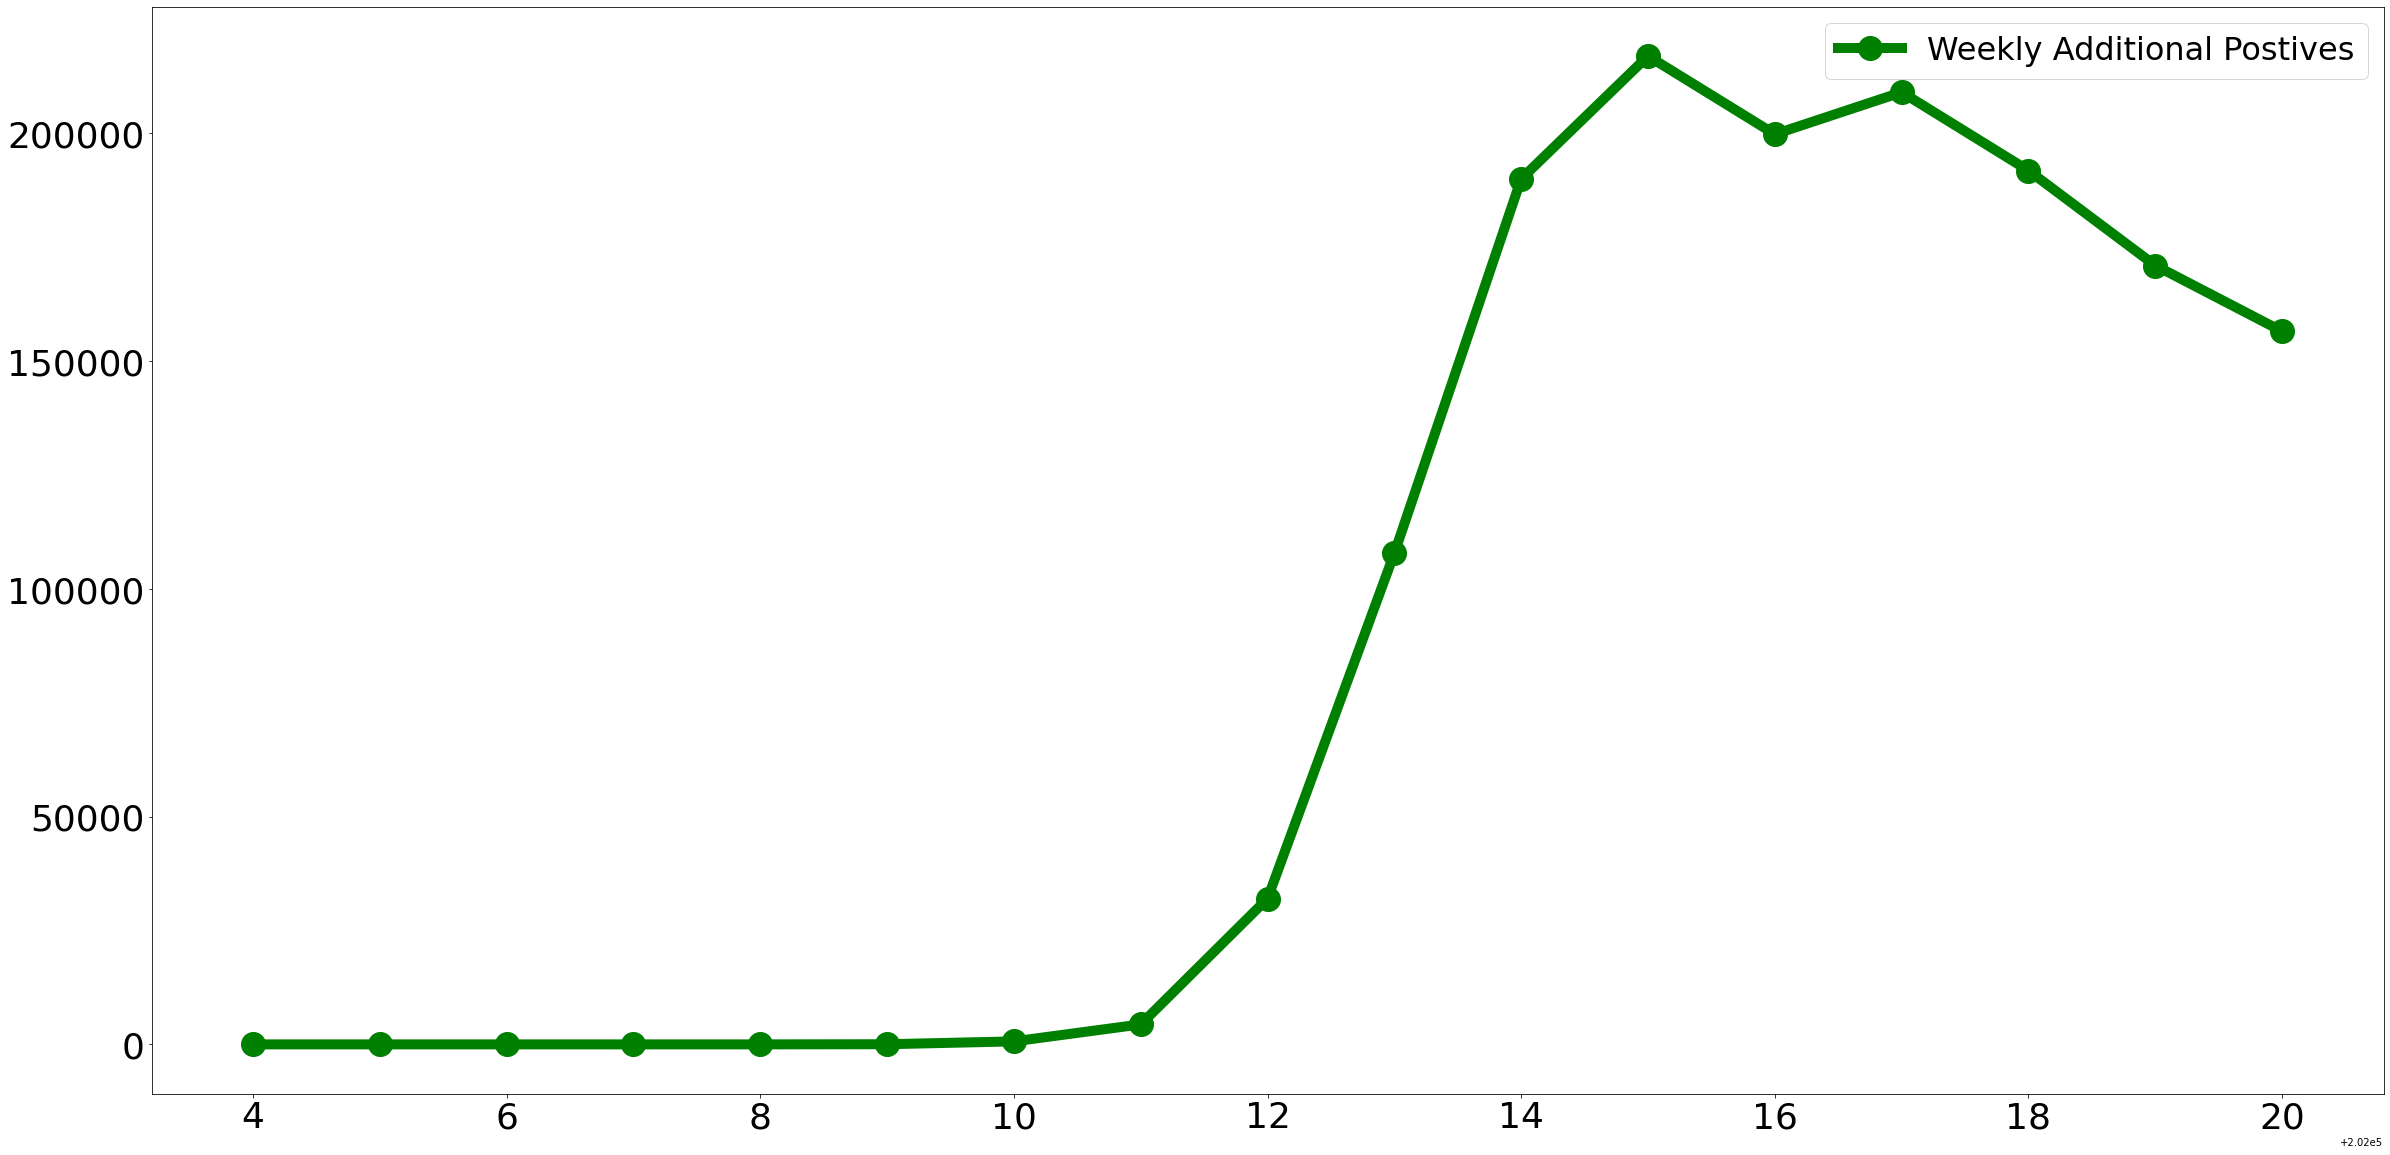

In [118]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

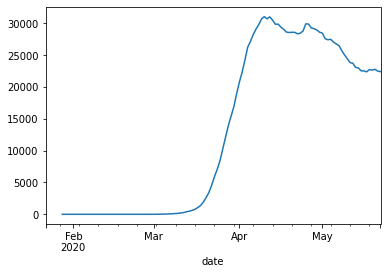

In [119]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

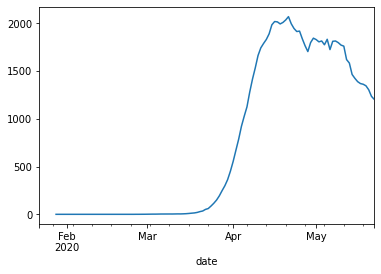

In [120]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

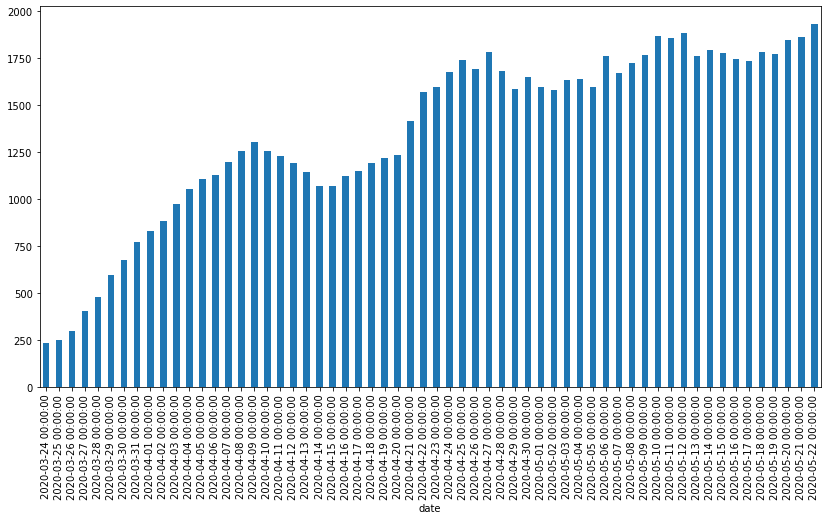

In [122]:

graph1 = dfCAAvg[20:].positiveIncrease.plot.bar(figsize=(14,7))


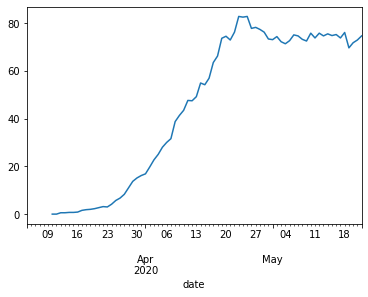

In [123]:
dfCAAvg.deathIncrease.plot.line()

In [124]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

,state,date,positive,death,total_positive,pct
774,FL,2020-05-22,49451,2268,49451,1.000000
775,FL,2020-05-21,48675,2222,49451,0.984308
776,FL,2020-05-20,47471,2173,49451,0.959960
777,FL,2020-05-19,46944,2129,49451,0.949303
778,FL,2020-05-18,46442,2073,49451,0.939152
779,FL,2020-05-17,45588,2049,49451,0.921882
780,FL,2020-05-16,44811,2040,49451,0.906170
781,FL,2020-05-15,43210,1991,49451,0.873794
782,FL,2020-05-14,43210,1948,49451,0.873794
783,FL,2020-05-13,42402,1898,49451,0.857455


In [125]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .75)].sort_values(by='pct')


,state,date,positive,death,total_positive,pct
1943,MN,2020-05-15,14240,692,19005,0.749277


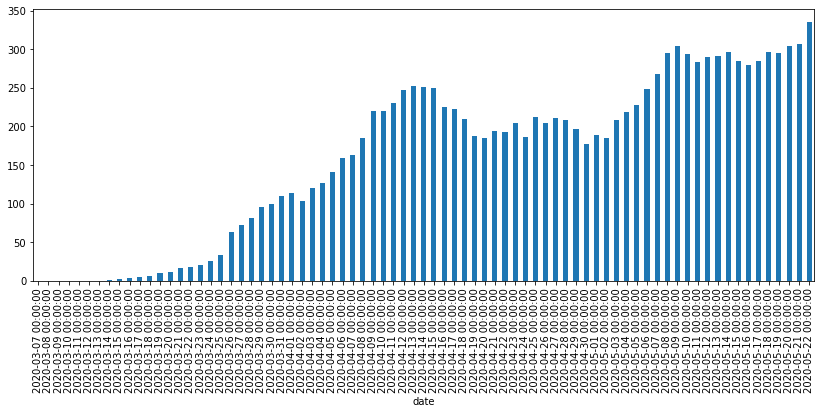

In [126]:

def showStateData(state):
  dfState = dfCovidtracking[dfCovidtracking.state==state].copy()
  dfState.date=pd.to_datetime(dfState.date)
  dfState.set_index('date', inplace=True)

  dfState[::-1].positiveIncrease.rolling(window=7).mean().plot.bar(figsize=(14,5))

showStateData('AL')


# State Population Data


In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [129]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


positive     1591475
negative    11826402
pending         3709
death          90156
total       13421586
dtype: int64
Current Infection Rate 11.857578%
Percentage of US affected: 0.512318%
Observed CFR: 5.664933%
Percentage of US tested/affected: 4.115298%
Projected affected by cir = 38,921,257
Projected killed = 2,204,864


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [137]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

,state_pos_pop,state_test_pop
state,,
NY,1.841072,8.228792
NJ,1.719385,6.251994
MA,1.318665,7.423196
RI,1.296631,12.001480
DC,1.118386,6.091826
CT,1.111832,5.674943
DE,0.875880,5.030582
IL,0.832114,5.501443
LA,0.794292,6.707288


In [138]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

Current Testing Percent 4.087831%


In [139]:
dfJHUData.columns

Index(['FIPS', 'city', 'state', 'country', 'last_update', 'lat', 'lon',
       'confirmed', 'dead', 'recovered', 'active', 'key'],
      dtype='object')

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [141]:
dfOwid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19078 entries, 0 to 19077
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         19014 non-null  object 
 1   location                         19078 non-null  object 
 2   date                             19078 non-null  object 
 3   total_cases                      19078 non-null  int64  
 4   new_cases                        19078 non-null  int64  
 5   total_deaths                     19078 non-null  int64  
 6   new_deaths                       19078 non-null  int64  
 7   total_cases_per_million          18701 non-null  float64
 8   new_cases_per_million            18701 non-null  float64
 9   total_deaths_per_million         18701 non-null  float64
 10  new_deaths_per_million           18701 non-null  float64
 11  total_tests                      5088 non-null   float64
 12  new_tests         

In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [144]:
dfOwidLatest.total_tests.sort_values(ascending=False)

iso_code
USA    13049906.0
RUS     8126626.0
ITA     3318778.0
DEU     3147771.0
IND     2615920.0
          ...    
MMR       17152.0
MDV       16846.0
CRI       15704.0
ZWE       15084.0
BOL       11273.0
Name: total_tests, Length: 85, dtype: float64

In [145]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

Total testing done outside of USA: 43406862
Total tests done in USA : 13049906
How many more times has the world tested more than the US: 3.3


In [146]:
dfOwidLatest[isUSA].sum()

location                                                         United States
date                                                                2020-05-21
total_cases                                                            1551853
new_cases                                                                23285
total_deaths                                                             93439
new_deaths                                                                1518
total_cases_per_million                                                4688.34
new_cases_per_million                                                   70.347
total_deaths_per_million                                               282.291
new_deaths_per_million                                                   4.586
total_tests                                                        1.30499e+07
new_tests                                                               402115
total_tests_per_thousand                            

In [147]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-7:]

,new_cases,new_deaths
date,,
2020-05-16,25508,1662
2020-05-17,24487,1186
2020-05-18,18873,808
2020-05-19,21841,791
2020-05-20,19970,1568
2020-05-21,23285,1518
2020-05-22,25434,1263


In [0]:
state = 'MN'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state].set_index('date')\
.rolling(window=7).sum()


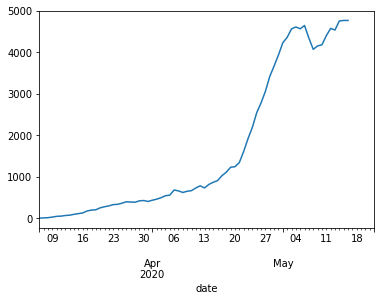

In [149]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [150]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

49451

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'].set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [152]:
doWGA.sum()

,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,280.0,859.0,39994.0,4677.0,44671.0
1,397.0,1444.0,62951.0,7143.0,70094.0
2,314.0,1647.0,55933.0,7257.0,63190.0
3,270.0,1029.0,48070.0,5816.0,53886.0
4,297.0,1139.0,76234.0,7598.0,83832.0
5,148.0,928.0,51800.0,4436.0,56236.0
6,79.0,267.0,51049.0,4289.0,55338.0


# Socrata (San Francisco) Data

In [153]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [156]:
results_df.case_disposition.unique()

array(['Confirmed', 'Death'], dtype=object)

In [0]:
res = results_df.astype({'case_count':'int16'})

In [0]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [159]:
dfresDead.groupby('date').sum()

,case_count
date,
2020-03-17T00:00:00.000,1
2020-03-24T00:00:00.000,1
2020-03-26T00:00:00.000,3
2020-03-27T00:00:00.000,2
2020-03-30T00:00:00.000,1
2020-03-31T00:00:00.000,1
2020-04-01T00:00:00.000,3
2020-04-05T00:00:00.000,1
2020-04-06T00:00:00.000,1


In [160]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail()

,new_cases
date,
2020-05-17T00:00:00.000,20
2020-05-18T00:00:00.000,27
2020-05-19T00:00:00.000,49
2020-05-20T00:00:00.000,29
2020-05-21T00:00:00.000,14


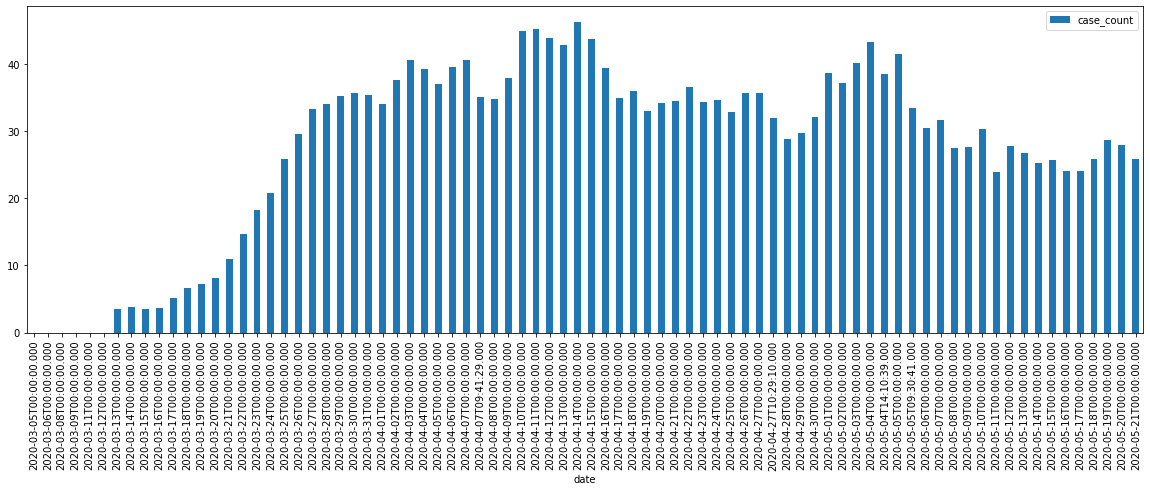

In [168]:
dfresConf.groupby('date').sum().rolling(window=7).mean().plot.bar(figsize=(20,6))

# Marin Data

In [0]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [163]:
df.tail()

,positive,deaths,tested,hospitalizations,Recovered
date,,,,,
2020-05-18,329,14.0,9137.0,48.0,231.0
2020-05-19,336,14.0,9500.0,49.0,232.0
2020-05-20,343,14.0,9889.0,50.0,238.0
2020-05-21,352,14.0,10189.0,50.0,244.0
2020-05-22,369,14.0,10694.0,50.0,251.0


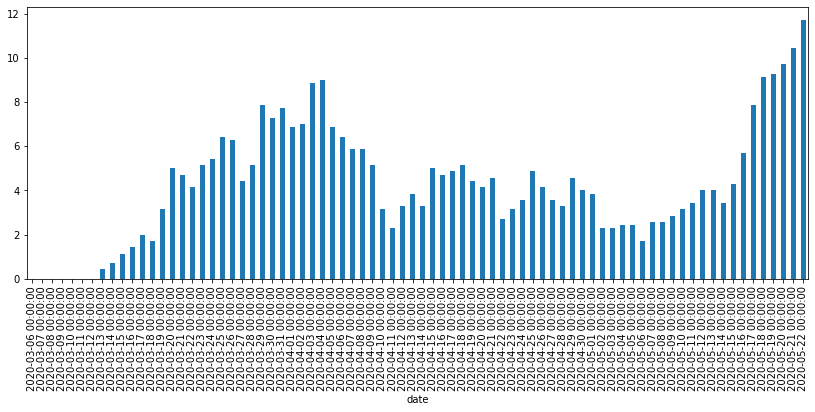

In [164]:
chart= df.positive.diff().rolling(window=7).mean().plot.bar(figsize=(14,5))

In [165]:
marin_pop = 259725

print(f"Marin Population Positive: {(df[-1:].positive.values[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested.values[0]/marin_pop)*100:2.2f}%")

Marin Population Positive: 0.14%
Marin Population Tested: 4.12%


In [166]:
df.positive.diff().rolling(window=7).mean().tail()

date
2020-05-18     9.142857
2020-05-19     9.285714
2020-05-20     9.714286
2020-05-21    10.428571
2020-05-22    11.714286
Name: positive, dtype: float64